# Evaluación de modelos (ejercicio)

### **Importante: comentar adecuadamente cada paso realizado**, relacionándolo con lo visto en la teoría.

Para este ejercicio usaremos de nuevo los datos de cáncer de mama que están accesibles en scikit-learn.

In [21]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

## Parte 1: validación cruzada estratificada

Se pide implementar una funcion `mi_cross_val_f1` que aplique validación cruzada con $k$ particiones estratificadas, y que use **$F_1$ como métrica**. Similar a la función `cross_val_score`, pero específicamente con particiones estratificadas y métrica $F_1$, **y obviamente sin usar `cross_val_score`**.  

En concreto, la función debe tener los siguientes argumentos de entrada, `mi_cross_val_f1`*(modelo,X,y,n_splits=5,clase_positiva=1)*, donde:

- *modelo* es un un clasificador (en particular, un objeto de una clase que tenga métodos `fit` y `predict`).
- *X* es un array con los datos.
- *y* es un array con la clasificación (binaria) de los datos anteriores.
- *n_splits* es el número de particiones en la validación cruzada. Por defecto es 5.
- *clase_positiva* la clase que se ha considerar como positiva cuando se calcule la métrica $F_1$. Por defecto es 1. Nótese que al calcular la métrica $F_1$ debemos saber qué clase es la que se considera como positiva.  

Debe devolver una lista o array con *n_splits* números, los resultados de las *n_splits* evaluaciones de la métrica $F_1$ que se realizan al aplicar validación cruzada con *n_splits* particiones estratificadas. 

**Nota**: no se puede usar `cross_val_score`, pero se debe usar `f1_score`y la clase `StratifiedKFold` (consultar la documentación de ambas)

---
#### 1.1 Stratified Cross-Validation Impl
*In this part I will implement a cross-validation method with k-partitions and $F_1$ as metric.*

In [22]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

*In this implementation I will be using the `StratifiedKFold` and `f1_score` from the scikit-learn library.*

- StratifiedKFold is simply a k-fold algorithm that divides the dataset into k *stratified* folds.
- $F_1$ scores are based on precision and recall relative to the label that is identified as the positive label in the binary classification. Because the $F_1$ score balances both precision and recall, it can be a very useful measure, especially if you are working with data where one of the classifications is overrepresented. What is meant by precision and recall can be simply explained:
    - Precision: When the model predicts a positive label for a data entry, how often is it correct?
    - Recall: How many of the actual positive data entries is the model labeling as the positive label?
    
    Keeping in mind this understanding of how $F_1$ scoring works, the reason for why we need the clase_positiva parameter is trivial.

In [23]:
def mi_cross_val_f1(modelo, X, y, n_splits=5, clase_positiva=1):
    ''' 
    Using stratified k-fold cross validation with f1 score as the metric
    to evaluate the model performance

    Parameters
    ----------
    modelo: modelo is the classifier to be used
    X: array-like
        X is the data
    y: array-like
        y is the target
    n_splits: int
        n_splits is the number of splits to be used in the cross validation
    clase_positiva: int
        clase_positiva is the positive class to be used in the f1 score
    
    Returns
    -------
    list
        A list with the f1 score for each fold
    '''
    # Using, as instructed in the task description the StratifiedKFold and f1_score from scikit-learn
    skf = StratifiedKFold(n_splits=n_splits)
    f1_scores = np.array([])

    # For each fold, we split the data into train and test, fit the model, predict and calculate the f1 score
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        f1_scores = np.append(f1_scores, f1_score(y_test, y_pred, pos_label=clase_positiva))
    return f1_scores

#### 1.2 Stratified Cross-Validation Testing

##### 1.2.1 Setup for Tests

In [24]:
# Import
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=0)

# Create the model
logreg=LogisticRegression(solver="liblinear")

In [25]:
def assert_close(f1_scores, cross_val_score):
    diffs = f1_scores - cross_val_score
    print("Difference between the expected and the actual result:")
    print(diffs)

    # Asserting that the difference is less than 1%
    assert np.allclose(a=diffs, b=np.zeros(len(diffs)), rtol=1e-5, atol=1e-5)

##### 1.2.2 Running Tests

In this part I control that the results from the new implementation of `mi_cross_val_f1` coincides with the scikit-learn cross-val score.

*Test 1*

In [26]:
#### Test 1 ####
#mi_cross_val_f1(logreg,X_train,y_train)
assert_close(mi_cross_val_f1(logreg,X_train,y_train), 
             cross_val_score(logreg,X_train,y_train,scoring=make_scorer(f1_score),cv=5))

Difference between the expected and the actual result:
[0. 0. 0. 0. 0.]


*Test 2*

In [27]:
#### Test 2 ####
# mi_cross_val_f1(logreg,X_train,y_train,n_splits=10)
assert_close(mi_cross_val_f1(logreg,X_train,y_train,n_splits=10), 
             cross_val_score(logreg,X_train,y_train,scoring=make_scorer(f1_score),cv=10))

Difference between the expected and the actual result:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


*Test 3*

In [28]:
#### Test 3 ####
# mi_cross_val_f1(logreg,X_train,y_train,n_splits=10,clase=0)
assert_close(mi_cross_val_f1(logreg,X_train,y_train,n_splits=10,clase_positiva=0), 
             cross_val_score(logreg,X_train,y_train,scoring=make_scorer(f1_score,pos_label=0),cv=10))

Difference between the expected and the actual result:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


---

## Parte 2: evaluación de modelos para datos del cáncer de mama

En esta parte supondremos que queremos encontrar un buen modelo para clasificación en el caso del cáncer de mama. Nos restingiremos a dos familias de clasificadores:

1. **SGDClassifier** con *loss="log"*. Es decir, regresión logística mediante descenso por el gradiente. 
2. **SVC**, máquina de vectores soporte con kernels.

En los datos del cáncer de mama, la clase 0 se corresponde con *maligno* y la clase 1 se corresponde con *benigno*. Supondremos también en esta sección que estamos interesado principalmente en el rendimiento sobre la detección del cáncer. Es decir, consideremos *maligno* como la clase positiva.

**Nota importante**: la clase positiva por defecto en scikit-learn es 1, y en este caso queremos considerar la clase 0 como la positiva. Para ello tenemos dos opciones:

- Usar el parámetro `pos_label` en las distintas funciones que usemos.
- Hacer una transformación inicial de las clases, para poner el 1 como 0 y el 0 como 1. Eso se consigue fácilmente haciendo `1-cancer.target`

In [29]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(cancer.data, 1-cancer.target, stratify=1-cancer.target, random_state=12)

# Scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Defining the labels
labels = ["Benign", "Malignant"]

### 2.1 *Grid Search* con validación cruzada



Aplicar `GridSearchCV` para ajustar hiperparámetros de los modelos `SGDClassifier`y `SVC`, aplicados al conjunto de datos del cáncer de mama.  En lugar de tratar de optimizar la tasa de aciertos, tratar de optimizar la métrica $F_1$ calculada considerando que los ejemplos de tumor "maligno" son los positivos. 

Tratar de encontrar valores optimos solo para aquellos hiperparámetos del modelo que te sean familiares y para valores de los que conozcas el significado. Probar con distintas rejillas. 

Una vez ajustados los dos modelos, dar para ambos:

- La tasa de aciertos, tanto en el conjunto de entrenamiento como en el de prueba.
- Matriz de confusión, tanto en entrenamiento como en prueba.
- *Classification report*, tanto para entrenamiento como para prueba. 

Interpretar los resultados. 


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

I will now apply GridSearchCV in order to adjust and improve on the hyperparameters for the models. GridSearchCV is a cross-validation based parameter grid search that, based on a grid of different possible parameters - trains and cross-validates a model for each possibility, to encounter the best parameter combination.

For the SGD params I am creating a parameter grid with the `alpha` regularization parameter, the `penalty` parameter, the `learning_rate` parameter, as well as the `eta0` parameter. The `alpa` regularization parameter controls regularization such that higher `alpha` values gives stronger regularization. Also for the SGD grid search I am including the `penalty` parameter, basically which regularization term to use: here I am choosing to test with *L1 regularization* and *L2 regularization*. The `learning_rate` parameter determines how the learning rate changes over time (e.g., constant, decreasing), while `eta0` is the initial learning rate when the `learning_rate` is set to *constant*, *invscaling*, or *adaptive*.

For the SVC grid search parameters I am controlling the `C` regularization parameter which for higher values leads to less regularization, opposite to that of the alpha parameter in the SGDClassifier. A low `C` value can lead to low bias but high variance (or overfitting), whilst a high `C` value can lead to high bias but low variance (or underfitting); it is thus important to also include in the testing. Furthermore, I am including the `gamma` parameter in the grid search, which represents the kernel coefficient used for *rbf*, *poly*, and *sigmoid* kernel functions - effectively altering the effect of each training example. Lastly, I am also trying different kernels by adjusting the `kernel` parameter.

In [31]:
# I will use the SGD classifier with the log loss function, which is the same as the logistic regression with gradient descent
sgd = SGDClassifier(loss="log_loss", max_iter=10000)
# Also initing the SVC with the default parameters
svc = SVC(max_iter=15000)

### Grid search ###
# Setting the parameters for the grid 
# Getting all possible parameters for the SGD classifier
params_sgd = {"alpha": [1e-4, 1e-3, 1e-2, 1e-1],
                "penalty": ["l1", "l2"],
                "learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
                "eta0": [0.01, 0.1, 1],}
params_svc = {"C": [1e-3, 1e-2, 1e-1, 1, 10],
                "gamma": [1e-4, 1e-3, 1e-2, 1e-1, "scale", "auto"],
                "kernel": ["linear", "poly", "rbf", "sigmoid"],
                "probability": [True, False],}
# Using the grid search with 5-fold cross validation and f1 score as the metric
grid_sgd = GridSearchCV(estimator=sgd, param_grid=params_sgd, scoring=make_scorer(f1_score), cv=5, n_jobs=-1)
grid_svc = GridSearchCV(estimator=svc, param_grid=params_svc, scoring=make_scorer(f1_score), cv=5, n_jobs=-1)

# Fitting the models
grid_sgd.fit(X_train_scaled, y_train)
grid_svc.fit(X_train_scaled, y_train)

# Printing the best parameters
print("Best parameters for SGD: ", grid_sgd.best_params_)
print("Best parameters for SVC: ", grid_svc.best_params_)

/Users/sindreoyen/Desktop/Sevilla/Aprendizaje Automatico/Excercises/Python-MachineLearning/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=15000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/sindreoyen/Desktop/Sevilla/Aprendizaje Automatico/Excercises/Python-MachineLearning/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=15000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Best parameters for SGD:  {'alpha': 0.01, 'eta0': 0.01, 'learning_rate': 'constant', 'penalty': 'l2'}
Best parameters for SVC:  {'C': 10, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}


/Users/sindreoyen/Desktop/Sevilla/Aprendizaje Automatico/Excercises/Python-MachineLearning/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=15000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


The results, as logged above are as follows:

- `Best parameters for SGD:  {'alpha': 0.01, 'eta0': 0.01, 'learning_rate': 'constant', 'penalty': 'l2'}`

- `Best parameters for SVC:  {'C': 10, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}`

*Now we can extract the best estimators for further analysis:*

In [32]:
# Best models for each classifier, from the grid search
best_sgd = grid_sgd.best_estimator_
best_sgd.fit(X_train_scaled, y_train)
best_svc = grid_svc.best_estimator_
best_svc.fit(X_train_scaled, y_train)

SVC(C=10, gamma=0.01, max_iter=15000, probability=True)

*For the analysis I am going to look at (1) the success rates of both models, (2) the confusion matrix for the classifications, as well as (3) the classification report*

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [34]:
def print_analysis(estimator, name):
    '''Function to print the analysis of the model, including the train and test score, the confusion matrix and the classification report

    Parameters
    ----------
    estimator: classifier
        estimator is the model to be analysed
    name: str
        name is the name of the model
    '''
    print("\n" + "#"*10 + f" Analysing the performance for the {name} model " + "#"*10)
    # Printing the hit-rate for the train and test data
    print("# (1) Hit accuracy")
    print("Train score: ", estimator.score(X_train_scaled, y_train))
    print("Test score: ", estimator.score(X_test_scaled, y_test))
    
    # Plotting the confusion matrix
    print("\n# (2) Confusion matrix")
    pred = estimator.predict(X_test_scaled)
    conf_mat = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
    disp.plot()
    plt.show()

    # Printing the classification report
    print("\n# (3) Classification report")
    print(classification_report(y_test, pred, target_names=labels))

##### 2.1.1 SGD Analysis


########## Analysing the performance for the SGD model ##########
# (1) Hit accuracy
Train score:  0.9859154929577465
Test score:  0.972027972027972

# (2) Confusion matrix


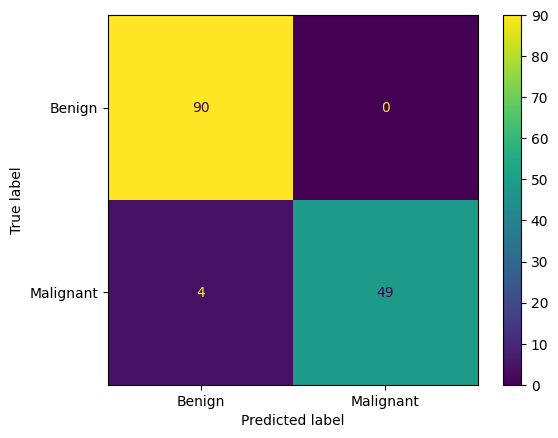


# (3) Classification report
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        90
   Malignant       1.00      0.92      0.96        53

    accuracy                           0.97       143
   macro avg       0.98      0.96      0.97       143
weighted avg       0.97      0.97      0.97       143



In [35]:
print_analysis(best_sgd, "SGD")

##### 2.1.2 SVC Analysis


########## Analysing the performance for the SVC model ##########
# (1) Hit accuracy
Train score:  0.9906103286384976
Test score:  0.9790209790209791

# (2) Confusion matrix


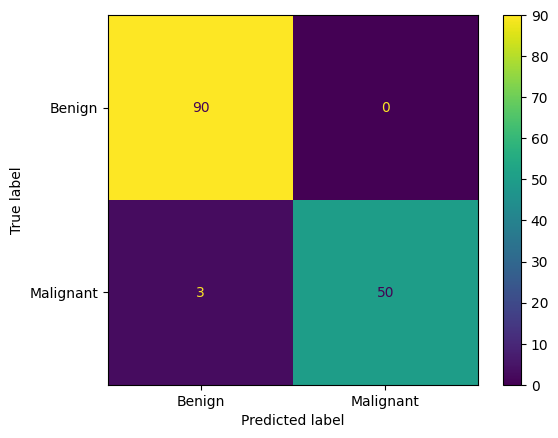


# (3) Classification report
              precision    recall  f1-score   support

      Benign       0.97      1.00      0.98        90
   Malignant       1.00      0.94      0.97        53

    accuracy                           0.98       143
   macro avg       0.98      0.97      0.98       143
weighted avg       0.98      0.98      0.98       143



In [36]:
print_analysis(best_svc, "SVC")

As is apparent in as of the results from the analysis, the performance of these models, as they stand now - is not optimal. Even though they have both a solid accuracy of around 97%, given the importance of the classifications - it is not good enough. There is still a >4-2% chance that you may have malignant cancer that will be coined as benign, which is scary. 

For this analysis, I could of course have analyzed more hyperparameters, but to save computational time I think this analysis is sufficient as a proof of concept. Depending on what use case these models would have, there are a lot of factors to take into account, overfitting e.g., is quintessential to be extremely wary of. The model may be close to 100% on the data defined using Holdout for the train-, test-, validate-split and still perform sub 90% on other sets; giving a false sense of security.

Furthermore, it is important to keep in mind the balance of the data in the datasets. If you have a dataset with e.g., 980 benign cases of cancer and 20 malignant cases of cancer - if the model were to predict wrong in all cases of malignant cancer, and correct in all benign, it would still be of 98% accuracy. Thus, understanding the confusion matrices, classification reports, as well as working with measures such as the $F_1$ scoring, is vital to get an actual understanding of the model's performance.

### 2.2 Curvas *ROC* y *PR*

Comparar ambos modelos construidos en el apartado anterior, dibujando sendas gráficas con las curvas ROC de ambos y con las curvas PR de ambos. Interretar las gráficas y calcular para ambos modelos la precisión media (*average precision*) y el área bajo la curva (*AUC*).

Interpretar los resultados.

##### 2.2.1 Methods for ROC and PR Analysis

**ROC Curve**

*The ROC curve is a plot of the True Positive Rate (TPR) vs. the False Positive Rate (FPR), considering various thresholds. The area under the ROC curve (AUC) is a measure of how well the model is able to distinguish between classes. An AUC of 1 represents a perfect - or almost perfect - model, while an AUC of 0.5 represents a model that is no better than random guessing.*

In [37]:
# Here I am using sklearns ROC assets to plot the ROC curve
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

def plot_roc_curve(estimator, name):
    '''Function to plot the ROC curve for the given model

    Parameters
    ----------
    estimator: classifier
        estimator is the model to be analysed
    name: str
        name is the name of the model
    '''
    print("\n" + "#"*10 + f" Plotting the ROC curve for the {name} model " + "#"*10)
    # Getting the probabilities for the positive class
    y_pred = estimator.predict(X_test_scaled)
    # Calculating the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    # Plotting the ROC curve
    roc_auc = roc_auc_score(y_test, y_pred)
    disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    disp.plot()
    plt.title(f"ROC curve for the {name} model")
    plt.show()

**PR Curve**

*The PR curve is a graph showing the trade-off between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.*

In [38]:
# Here I am using sklearns Precision Recall assets to plot the PR curve
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

def plot_pr_curve(estimator, name):
    '''Function to plot the PR curve for the given model

    Parameters
    ----------
    estimator: classifier
        estimator is the model to be analysed
    name: str
        name is the name of the model
    '''
    print("\n" + "#"*10 + f" Plotting the PR curve for the {name} model " + "#"*10)
    # Getting the probabilities for the positive class
    y_pred = estimator.predict(X_test_scaled)
    # Calculating the PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred, pos_label=1)
    # Plotting the PR curve
    average_precision = average_precision_score(y_test, y_pred)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision, estimator_name=name)
    disp.plot()
    plt.title(f"Precision-Recall curve for {name}")
    plt.show()

##### 2.2.2 SGD Analysis: ROC and PR


########## Plotting the ROC curve for the SGD model ##########


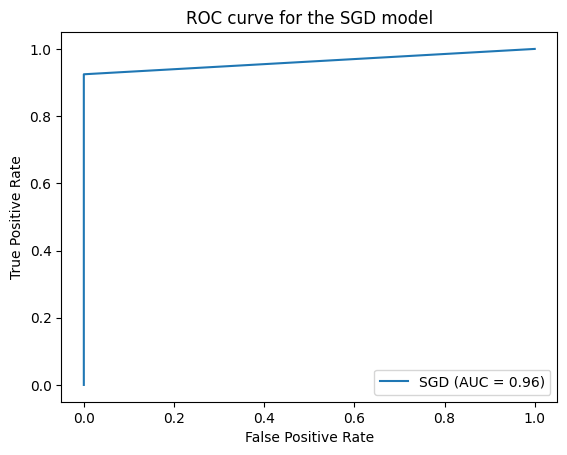


########## Plotting the PR curve for the SGD model ##########


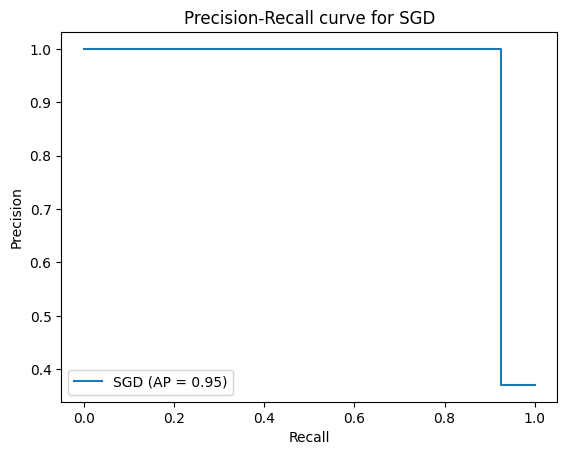

In [39]:
plot_roc_curve(best_sgd, "SGD")
plot_pr_curve(best_sgd, "SGD")

##### 2.2.3 SVC Analysis: ROC and PR


########## Plotting the ROC curve for the SVC model ##########


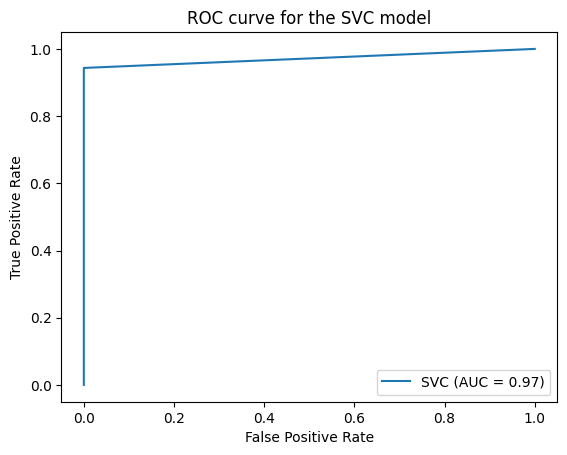


########## Plotting the PR curve for the SVC model ##########


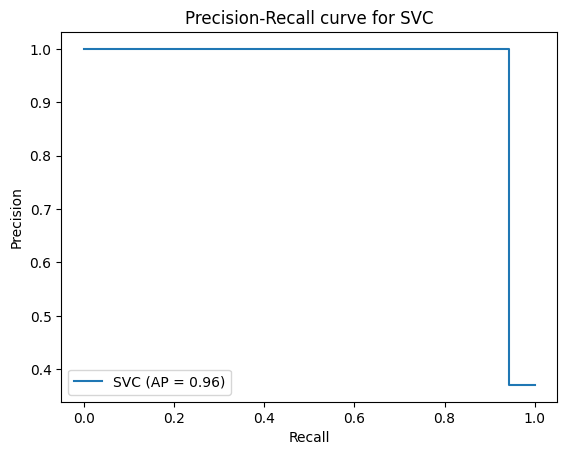

In [40]:
plot_roc_curve(best_svc, "SVC")
plot_pr_curve(best_svc, "SVC")